# French to English Machine Translation  
## Seq2Seq with attention & learned embeddings 

Import Libraries

In [ ]:
!pip install bcolz

     |████████████████████████████████| 1.5MB 5.6MB/s 


In [ ]:
!pip install translate

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os, pickle, collections, bcolz
import operator
import itertools 
import gensim
from termcolor import colored
from translate import Translator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ANSI Color Codes

In [ ]:
bold_blue_font_tag = '\x1b[1m\x1b[34m'
bold_red_font_tag = '\x1b[1m\x1b[31m'
red_font_tag = '\u001b[31m'
bold_green_font_tag = '\x1b[1m\x1b[32m'
magenta = '\033[35m'
bold = '\033[1m'
reset = '\033[0m'

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Set the path to these files. They should be in the shared folder. Copy to your drive, or upload to colab instance.

In [ ]:
# dataset
dataset_path = '/content/drive/My Drive/MT/eng-fra.txt'

# model weights
encoder_weights_path = '/content/drive/My Drive/encoder1_250000_0.0955.pth'
decoder_weights_path = '/content/drive/My Drive/attn_decoder1_250000_0.0955.pth'

Make sure GPU is available

In [ ]:
torch.cuda.is_available()

True

Create class to create vocab dictionaries

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Preprocess text: lowercase, remove some punc., convert to Ascii

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

Function to read sentences, preprocess text, create vocab dictionaries

In [ ]:
def readLangs(reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(dataset_path, encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang('fra')
        output_lang = Lang('eng')
    else:
        input_lang = Lang('eng')
        output_lang = Lang('fra')

    return input_lang, output_lang, pairs

Filtering dataset by length and prefix

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

      
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Calling everything above to prepare data

In [ ]:
def prepareData(reverse=False):
    input_lang, output_lang, pairs = readLangs(reverse)
    pre_len = len(pairs)
    print("\nRead %s sentence pairs" % pre_len)
    pairs = filterPairs(pairs)
    post_len = len(pairs)
    print(f'Trimmed to {post_len} sentence pairs ')
    print(f'Using {post_len/pre_len * 100:.2f}% of dataset')

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData(True)
print(f'\nExample pair of sentences: {random.choice(pairs)}')

Reading lines...

Read 135842 sentence pairs
Trimmed to 10599 sentence pairs 
Using 7.80% of dataset

Example pair of sentences: ['je suis desolee de vous avoir blesses .', 'i m sorry i hurt you .']


Class for encoder

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Class for decoder with attention

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Converting to tensors

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training function

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

Functions to keep track of time

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

Function to run training

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    return plot_losses

Plot loss curve after training

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Function to evaluate after training

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

Calculating bleu score

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def bleu(reference,candidate):
  one_gram = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
  return (one_gram)

Calculating Gleu score

In [ ]:
from nltk.translate.gleu_score import sentence_gleu

def gleu(reference, candidate):
  one_gram = sentence_gleu(reference, candidate)
  return (one_gram)

Custom score

In [ ]:
# create a custom score by averaging bs and gs scores with weights
# adding a bonus if different words have a shared semantic meaning (cs score > 0.3)
# subtracting points if predicted sequence has duplicated words
# inputs: bleu score, gleu score, # of double words in pred
# outputs: custom score

def custom_score(bs,gs,cs,double_word_penalty, verbose=True):
  total = ((bs*.75)+(gs*.25)) # weighted avg
  cs_bonus = 0

  # calc cs bonus
  def get_bonus(cs,multiplier = .4):
    additional = 0
    for i in cs:
      additional += i * multiplier
    return additional

  # if we have similarities, compute bonus
  if cs: 
    cs_bonus = get_bonus(cs)


  # if perfect score, return 1
  if bs == 1:
    if verbose:
      print('\nSemantic similarity bonus : +', float(cs_bonus))
      print('Double word penalty:        -', double_word_penalty * .1,'\n')
    return 1.00

  else:
    if cs_bonus:
      grand_total = total + cs_bonus
      if grand_total < 1:
        if verbose:
          print('\nSemantic similarity bonus : +', float(cs_bonus))
          print('Double word penalty:        -', double_word_penalty * .1,'\n')
        return grand_total

      # bonus put score over 1  
      else:
        cs_bonus = get_bonus(cs, multiplier = .3)
        if verbose:
          print('\nTotal score > 1, adjusting weights...') #debug statement, delete at end
          print('\nSemantic similarity bonus : +', float(cs_bonus))
          print('Double word penalty:        -', double_word_penalty * .1,'\n')
        grand_total = total + cs_bonus
        if grand_total < 1:   
          return grand_total

        # bonus put score over 1   
        else:
          cs_bonus = get_bonus(cs, multiplier = .2)
          grand_total = total + cs_bonus
          if grand_total < 1:  
            return grand_total
          else:
            cs_bonus = get_bonus(cs, multiplier = .1)
            grand_total = total + cs_bonus
            if grand_total < 1:   
              return grand_total



    # if no cs bonus      
    else:
      if verbose:
        print('\nSemantic similarity bonus : +', float(cs_bonus))
        print('Double word penalty:        -', double_word_penalty * .1,'\n')
      return total - (double_word_penalty * .1)

Fix output contractions

In [ ]:
# fix issues with contractions when displaying results.
# issues: 's' could represent possesion and not 'is.' Small fraction of the time though.
# inputs: two lists of words
# outputs: two lists of words

def fix_contractions(ref,pred):
  for idx, word in enumerate(pred):
    if word == 're':
      pred[idx] = 'are'
    elif word == 'm':
      pred[idx] = 'am' 
    elif word == 's':
      pred[idx] = 'is'   
    elif word == 'ok':
      pred[idx] = 'okay'  
    elif (word == 'aren' and pred[idx+1] == 't'):
      pred[idx] = 'are' 
      pred[idx+1] = 'not'
    elif (word == 'isn' and pred[idx+1] == 't'):
      pred[idx] = 'is' 
      pred[idx+1] = 'not'
    elif (word == 'don' and pred[idx+1] == 't'):
      pred[idx] = 'do' 
      pred[idx+1] = 'not'

  for idx, rword in enumerate(ref):
    if rword == 're':
      ref[idx] = 'are'
    elif rword == 'm':
      ref[idx] = 'am' 
    elif rword == 'ok':
      ref[idx] = 'okay'       
    elif rword == 's':
      ref[idx] = 'is'  
    elif (rword == 'aren' and ref[idx+1] == 't'):
      ref[idx] = 'are' 
      ref[idx+1] = 'not'        
    elif (rword == 'isn' and ref[idx+1] == 't'):
      ref[idx] = 'is' 
      ref[idx+1] = 'not' 
    elif (rword == 'don' and ref[idx+1] == 't'):
      ref[idx] = 'do' 
      ref[idx+1] = 'not' 

  return ref, pred

Fix Punctuation

In [ ]:
# sometimes ending punctuation is filtered off prediction when no EOS token is predicted
# adding it back in to not trigger missed prediction
# input: two lists of words
# output: two lists of words

def fix_punctuation(ref, pred):
  ending_punc = [ref[-1]]
  if pred[-1] not in ending_punc:
    pred.append(ending_punc[0])
  return ref, pred

Initialize models and start training

3m 11s (- 76m 47s) (10000 4%) 2.5727
6m 17s (- 72m 21s) (20000 8%) 1.8617
9m 23s (- 68m 53s) (30000 12%) 1.4468
12m 29s (- 65m 36s) (40000 16%) 1.1702
15m 31s (- 62m 6s) (50000 20%) 0.9401
18m 30s (- 58m 36s) (60000 24%) 0.7839
21m 31s (- 55m 20s) (70000 28%) 0.6468
24m 31s (- 52m 7s) (80000 32%) 0.5575
27m 31s (- 48m 56s) (90000 36%) 0.4719
30m 32s (- 45m 48s) (100000 40%) 0.3963
33m 33s (- 42m 42s) (110000 44%) 0.3515
36m 34s (- 39m 37s) (120000 48%) 0.2872
39m 34s (- 36m 32s) (130000 52%) 0.2535
42m 34s (- 33m 27s) (140000 56%) 0.2357
45m 34s (- 30m 22s) (150000 60%) 0.2107
48m 36s (- 27m 20s) (160000 64%) 0.2001
51m 42s (- 24m 20s) (170000 68%) 0.1774
54m 42s (- 21m 16s) (180000 72%) 0.1664
57m 42s (- 18m 13s) (190000 76%) 0.1650
60m 41s (- 15m 10s) (200000 80%) 0.1536
63m 40s (- 12m 7s) (210000 84%) 0.1408
66m 41s (- 9m 5s) (220000 88%) 0.1345
69m 42s (- 6m 3s) (230000 92%) 0.1215
72m 44s (- 3m 1s) (240000 96%) 0.1184
75m 46s (- 0m 0s) (250000 100%) 0.1118


<Figure size 432x288 with 0 Axes>

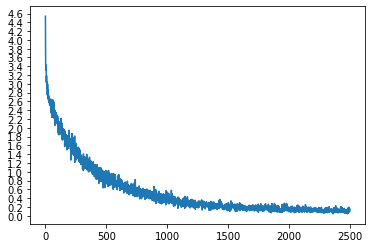

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

#trainIters(encoder1, attn_decoder1, 90000, print_every=5000)
loss_tracker = trainIters(encoder1, attn_decoder1, 250000, print_every=10000)

Save losses for plotting

In [ ]:
loss_tracker

In [ ]:
with open('/content/scratch_w_attn.pkl', 'wb') as f:
  pickle.dump(loss_tracker, f)

In [ ]:
from google.colab import files
files.download('/content/scratch_w_attn.pkl') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Load model weights from drive

In [ ]:
encoder1.load_state_dict(torch.load(encoder_weights_path))

<All keys matched successfully>

In [ ]:
attn_decoder1.load_state_dict(torch.load(decoder_weights_path))

<All keys matched successfully>

Save weights after training

In [ ]:
#torch.save(encoder1.state_dict(), 'encoder1_0.3811.pth')

In [ ]:
#torch.save(attn_decoder1.state_dict(), 'attn_decoder1_0.3811.pth')

Two new WE models for cosine sim.: word2vec and Finnish Parsebank

Both these .bin files are in the shared drive

In [ ]:
# w2v WE model:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/Embedding Models/word2vec.bin', binary=True)

Calculate cosine similiarities

In [ ]:
# calculates penalties for double words, filters sentences to relevant words to compare,
# calculateds cos. sim., and a score for the strength of the cos. sims.
# inputs: two lists of words
# outputs: relevant word cosine sim. scores over 0.3, number of double words in the prediction

def similarities(A,B,verbose=True):

  # does B have more double words than A? 
  doublesA = 0
  doublesB = 0
  basketA = []
  basketB = []

  for i in A:
    if i not in basketA:
      basketA.append(i)
    else:
      doublesA += 1

  for i in B: 
    if i not in basketB:
      basketB.append(i)
    else:
      doublesB += 1

  # calc penalty, keep only positive values
  double_word_penalty = np.clip(doublesB - doublesA, 0,3) 

  # get words not in the other sentence and not in punc/stopwords
  stop_words = ['a','an','of','the','to','on','t','in','as'] #,'not','no']
  punc = ['.','?','!',',']
  extraW = [] # all extra words
  extraA = []
  extraB = []

  for i in A:
    if i not in punc:
      if i not in stop_words:
        if (i not in B):
          extraA.append(i)
  for i in B:
    if i not in punc:
      if i not in stop_words:
        if (i not in A):
          extraB.append(i)

  extraW = extraA + extraB

  # if off by one word, exit
  if len(extraW) == 1:
    return [0, double_word_penalty]
  
  # calc cos sims and score
  sim_finn = []
  sim_w2v = []
  record = []

  for a, b in itertools.product(extraA,extraB):
    sim_w2v.append([a,b,w2v_model.similarity(a,b)])

  sorted_sim_w2v = sorted(sim_w2v, key = lambda x: x[2], reverse=True)

  cs_score = [0] #list of cs over 0.3

  # print cs scores
  if sorted_sim_w2v:
    if verbose:
      print('\nSemantic similarities using w2v:')
    for idx,i in enumerate(sorted_sim_w2v):
      if verbose:
        if i[2] > 0.3:
          print(bold, end="")
          print('  ',i,reset)
        else:
          print('  ',i)
    #print('\n')
    # record cs scores
    for i in sorted_sim_w2v:
      if i[2] > 0.3:
        cs_score.append(i[2])

  return [cs_score, double_word_penalty]

Google Translate API

In [ ]:
# run text through google translate api
# input: string
# output: string

def google_translate(text):
  translator= Translator(from_lang="french",to_lang="english")
  translation = translator.translate(text)
  return translation

Evalue whole dataset

In [ ]:
# evaluate n random pairs from dataset
# input: models, n
# output: none

def evaluateAll(encoder, decoder, n=1000, all = False):
    print(bold+'Evaluation of Machine Translation Models'+reset)
    
    #scratch
    bleu_score_tracker = []
    gleu_score_tracker = []
    custom_tracker = []

    #glove
    glove_bleu_score_tracker = []
    glove_gleu_score_tracker = []
    glove_custom_tracker = []

    record_test = []
    ending_punc = ['.','?','!']

    if not all: # run on n randomly chosen pairs
      print(bold+'Evaluating ',n,' examples...'+reset)

      # get random indices to pull data from
      rand_indices = [random.randint(0,len(pairs)-1) for i in range(n)]

      for i in rand_indices:

          pair = pairs[i]
          # create lookup table for pairs including idx for easy look up
          output_words, attentions = evaluate(encoder, decoder, pair[0])  
          
          ###### preprocess function#######
          ref = pair[1].split()#[:-1]
          pred = output_words[:-1]

          # fix contractions
          ref, pred = fix_contractions(ref, pred)

          # if missing ending punctuation
          if pred[-1] not in ending_punc:
            ref, pred = fix_punctuation(ref, pred) 

          ###### look up other model pred function#######
          # get glove prediction
          glove = glove_frwac_df['Prediction'][i] #************

          ###### get scores function#######
          bleu_one_gram = bleu([ref[:-1]],pred[:-1])
          glove_bleu = bleu([ref[:-1]],glove[:-1])#************

          # DO NOT DISPLAY PERFECT SCORES - USED FOR EASY DEBUGGING - DELETE AT END
          # CONVERT TO DISPLAYING PERFECT SCORES SOME FRACTION OF THE TIME (1/5TH?)
          if bleu_one_gram < 1:
            print('\n')
            print(bold+'Input:\t'+reset, pair[0])
            print(bold+'Target:\t'+reset, ' '.join(ref))


            print(bold+'S-Pred:\t'+reset, ' '.join(pred))
            print(bold+'G-Pred:\t'+reset, ' '.join(glove),'\n')#************
            
            # requires ref to be a 2d list, pred 1d list
            bleu_score_tracker.append(bleu_one_gram)
            gleu_one_gram = gleu([ref[:-1]],pred[:-1])
            gleu_score_tracker.append(gleu_one_gram)
            print(f'Scratch Bleu Score: {bleu_one_gram:.3f}')
            print(f'Scratch Gleu Score: {gleu_one_gram:.3f}')
            print(f'Scratch Avg Score:  {(gleu_one_gram*.25+bleu_one_gram*.75):.3f}') #weighted

            glove_bleu_score_tracker.append(glove_bleu)#************
            glove_gleu = gleu([ref[:-1]],glove[:-1])#************
            glove_gleu_score_tracker.append(glove_gleu)#************
            print(f'Glove Bleu Score: \t{glove_bleu:.3f}')
            print(f'Glove Gleu Score: \t{glove_gleu:.3f}')
            print(f'Glove Avg Score:  \t{(glove_gleu*.25+glove_bleu*.75):.3f}') #weighted
            

            
            cs_score = 0

            # if not perfect score: calc. bonuses and penalties
            if bleu_one_gram < 1:
              try: # sometimes sims returns none
                sim_returns = similarities(ref,pred)
                cs_score = sim_returns[0]
                double_word_penalty = sim_returns[1]
                cust_score = custom_score(bleu_one_gram,gleu_one_gram,cs_score,double_word_penalty)
                print(f'{bold_red_font_tag}S-Custom Score: {cust_score:.3f}{reset}')

              # if word not in WE
              except KeyError:
                print('Cosine similarities: Word not found in embedding vocabulary')
                continue
            else:
              cust_score = custom_score(bleu_one_gram,gleu_one_gram,0,0)
              print(f'{bold_red_font_tag}S-Custom Score: {cust_score:.3f}{reset}')

            custom_tracker.append(cust_score)


            if glove_bleu < 1:
              try: # sometimes sims returns none
                glove_sim_returns = similarities(ref,glove)
                glove_cs_score = glove_sim_returns[0]
                glove_double_word_penalty = glove_sim_returns[1]
                glove_cust_score = custom_score(glove_bleu,glove_gleu,glove_cs_score,glove_double_word_penalty)
                print(f'{bold_red_font_tag}G-Custom Score: {glove_cust_score:.3f}{reset}')
                #print('\n')

              # if word not in WE
              except KeyError:
                print('Cosine similarities: Word not found in embedding vocabulary')
                continue
            else:
              glove_cust_score = custom_score(glove_bleu,glove_gleu,0,0)
              print(f'{bold_red_font_tag}G-Custom Score: {glove_cust_score:.3f}{reset}')

            glove_custom_tracker.append(glove_cust_score)


      print('\n')
      print(f'{bold_blue_font_tag}Avg S-Bleu Score  :{reset} {sum(bleu_score_tracker)/len(bleu_score_tracker):.3f}')
      print(f'{bold_blue_font_tag}Avg S-Gleu Score  :{reset} {sum(gleu_score_tracker)/len(gleu_score_tracker):.3f}')
      print(f'{bold_blue_font_tag}Avg S-Custom Score:{reset} {sum(custom_tracker)/len(custom_tracker):.3f}')

      print('\n')
      print(f'{bold_blue_font_tag}Avg G-Bleu Score  :{reset} {sum(glove_bleu_score_tracker)/len(glove_bleu_score_tracker):.3f}')
      print(f'{bold_blue_font_tag}Avg G-Gleu Score  :{reset} {sum(glove_gleu_score_tracker)/len(glove_gleu_score_tracker):.3f}')
      print(f'{bold_blue_font_tag}Avg G-Custom Score:{reset} {sum(glove_custom_tracker)/len(glove_custom_tracker):.3f}')

    else: # run on entire dataset
      print(bold+'Evaluating entire dataset...'+reset)
      for i in range(len(pairs)):
        pair = pairs[i]
        output_words, attentions = evaluate(encoder, decoder, pair[0])  
        ref = pair[1].split()#[:-1]
        pred = output_words[:-1]

        # fix contractions
        ref, pred = fix_contractions(ref, pred)

        # if missing ending punctuation
        if pred[-1] not in ending_punc:
          ref, pred = fix_punctuation(ref, pred) 

        bleu_one_gram = bleu([ref[:-1]],pred[:-1])
        bleu_score_tracker.append(bleu_one_gram)
        gleu_one_gram = gleu([ref[:-1]],pred[:-1])
        gleu_score_tracker.append(gleu_one_gram)

        cs_score = 0

        # if not perfect score: calc. bonuses and penalties
        if bleu_one_gram < 1:
          try: # sometimes sims returns none
            sim_returns = similarities(ref,pred, verbose=False)
            cs_score = sim_returns[0]
            double_word_penalty = sim_returns[1]
            cust_score = custom_score(bleu_one_gram,gleu_one_gram,cs_score,double_word_penalty, verbose=False)
            #print(bold_red_font_tag+'Custom Score: ',cust_score,reset)
            #print('\n')

          # if word not in WE
          except KeyError:
            #print('Cosine similarities: Word not found in embedding vocabulary')
            continue
        else:
          cust_score = custom_score(bleu_one_gram,gleu_one_gram,0,0, verbose=False)
          #print(bold_red_font_tag+'Custom Score: ',cust_score,reset)

        custom_tracker.append(cust_score)

      print('\n')
      print(f'{bold_blue_font_tag}Avg Bleu Score  :{reset} {sum(bleu_score_tracker)/len(bleu_score_tracker):.3f}')
      print(f'{bold_blue_font_tag}Avg Gleu Score  :{reset} {sum(gleu_score_tracker)/len(gleu_score_tracker):.3f}')
      print(f'{bold_blue_font_tag}Avg Custom Score:{reset} {sum(custom_tracker)/len(custom_tracker):.3f}')

Load results from other models

In [ ]:
with open('/content/drive/MyDrive/Embedding Models/glove_frwac_results.pkl', 'rb') as f:
  glove_frwac_results = pickle.load(f)

with open('/content/drive/MyDrive/Embedding Models/ft_frwac_results_V1.pkl', 'rb') as f:
  ft_frwac_results = pickle.load(f)

with open('/content/drive/MyDrive/Embedding Models/w2v_frwac_results_V2.pkl', 'rb') as f:
  w2v_frwac_results = pickle.load(f)

In [ ]:
# Idx is the index of the sentence in the pairs dataset

import pandas as pd
glove_frwac_df = pd.DataFrame(glove_frwac_results, columns=['Idx','Ref','Prediction'])
#glove_frwac_df.sample(3)

In [ ]:
#w2v_frwac_df = pd.DataFrame(w2v_frwac_results, columns=['Idx','Ref','Prediction'])
w2v_frwac_df.sample(3)

In [ ]:
ft_frwac_df = pd.DataFrame(ft_frwac_results, columns=['Idx','Ref','Prediction'])
#ft_frwac_df.sample(3)

Evaluate n examples of pairs

In [ ]:
# evaluate n random pairs from dataset
# input: models, n
# output: none

def evaluateRandomlySimplifiedOutput(encoder, decoder, n=1000):
    print(bold+'Evaluation of Machine Translation Models'+reset)
    
    #scratch
    bleu_score_tracker = []
    gleu_score_tracker = []
    custom_tracker = []

    #glove
    glove_bleu_score_tracker = []
    glove_gleu_score_tracker = []
    glove_custom_tracker = []

    #w2v
    w2v_bleu_score_tracker = []
    w2v_gleu_score_tracker = []
    w2v_custom_tracker = []

    #ft
    ft_bleu_score_tracker = []
    ft_gleu_score_tracker = []
    ft_custom_tracker = []

    record_test = []
    ending_punc = ['.','?','!']

    print(bold+'Evaluating ',n,' examples...'+reset)

    # get random indices to pull data from
    rand_indices = [random.randint(0,len(pairs)-1) for i in range(n)]

    for i in rand_indices:

        pair = pairs[i]
        # create lookup table for pairs including idx for easy look up
        output_words, attentions = evaluate(encoder, decoder, pair[0])  
        
        ###### preprocess function#######
        ref = pair[1].split()#[:-1]
        pred = output_words[:-1]

        # fix contractions
        ref, pred = fix_contractions(ref, pred)

        # if missing ending punctuation
        if pred[-1] not in ending_punc:
          ref, pred = fix_punctuation(ref, pred) 

        ###### look up other model pred function#######
        # get glove prediction
        glove = glove_frwac_df['Prediction'][i] #************

        # get w2v prediction
        w2v = w2v_frwac_df['Prediction'][i] #************

        # get fasttext prediction
        ft = ft_frwac_df['Prediction'][i] #************


        ###### get scores function#######
        bleu_one_gram = bleu([ref[:-1]],pred[:-1])
        glove_bleu = bleu([ref[:-1]],glove[:-1])#************
        w2v_bleu = bleu([ref[:-1]],w2v[:-1])#************
        ft_bleu = bleu([ref[:-1]],ft[:-1])#************


        # DO NOT DISPLAY PERFECT SCORES - USED FOR EASY DEBUGGING - DELETE AT END
        # CONVERT TO DISPLAYING PERFECT SCORES SOME FRACTION OF THE TIME (1/5TH?)
        if bleu_one_gram < 1:
          print('\n')
          print(bold+'Input:\t'+reset, pair[0])
          print(bold+'Target:\t'+reset, ' '.join(ref),'\n')


          print(bold+'G-Pred:\t'+reset, ' '.join(glove))#************
          print(bold+'W-Pred:\t'+reset, ' '.join(w2v))#************
          print(bold+'F-Pred:\t'+reset, ' '.join(ft))#************
          print(bold+'S-Pred:\t'+reset, ' '.join(pred),'\n')

          # requires ref to be a 2d list, pred 1d list
          bleu_score_tracker.append(bleu_one_gram)
          gleu_one_gram = gleu([ref[:-1]],pred[:-1])
          gleu_score_tracker.append(gleu_one_gram)

          glove_bleu_score_tracker.append(glove_bleu)#************
          glove_gleu = gleu([ref[:-1]],glove[:-1])#************
          glove_gleu_score_tracker.append(glove_gleu)#************

          w2v_bleu_score_tracker.append(w2v_bleu)#************
          w2v_gleu = gleu([ref[:-1]],w2v[:-1])#************
          w2v_gleu_score_tracker.append(w2v_gleu)#************

          ft_bleu_score_tracker.append(ft_bleu)#************
          ft_gleu = gleu([ref[:-1]],ft[:-1])#************
          ft_gleu_score_tracker.append(ft_gleu)#************

          cs_score = 0

          # if not perfect score: calc. bonuses and penalties
          if bleu_one_gram < 1:
            try: # sometimes sims returns none
              sim_returns = similarities(ref,pred,verbose=False)
              cs_score = sim_returns[0]
              double_word_penalty = sim_returns[1]
              cust_score = custom_score(bleu_one_gram,gleu_one_gram,cs_score,double_word_penalty,verbose=False)

            # if word not in WE
            except KeyError:
              continue
          else:
            cust_score = custom_score(bleu_one_gram,gleu_one_gram,0,0,verbose=False)

          custom_tracker.append(cust_score)

          # glove
          if bleu_one_gram < 1:
            try: # sometimes sims returns none
              glove_sim_returns = similarities(ref,glove,verbose=False)
              glove_cs_score = glove_sim_returns[0]
              glove_double_word_penalty = glove_sim_returns[1]
              glove_cust_score = custom_score(glove_bleu,glove_gleu,glove_cs_score,glove_double_word_penalty,verbose=False)

            # if word not in WE
            except KeyError:
              continue
          else:
            glove_cust_score = custom_score(glove_bleu,glove_gleu,0,0,verbose=False)

          glove_custom_tracker.append(glove_cust_score)

          # w2v
          if bleu_one_gram < 1:
            try: # sometimes sims returns none
              w2v_sim_returns = similarities(ref,w2v,verbose=False)
              w2v_cs_score = w2v_sim_returns[0]
              w2v_double_word_penalty = w2v_sim_returns[1]
              w2v_cust_score = custom_score(w2v_bleu,w2v_gleu,w2v_cs_score,w2v_double_word_penalty,verbose=False)

            # if word not in WE
            except KeyError:
              continue
          else:
            w2v_cust_score = custom_score(w2v_bleu,w2v_gleu,0,0,verbose=False)

          w2v_custom_tracker.append(w2v_cust_score)

          # ft
          if bleu_one_gram < 1:
            try: # sometimes sims returns none
              ft_sim_returns = similarities(ref,ft,verbose=False)
              ft_cs_score = ft_sim_returns[0]
              ft_double_word_penalty = ft_sim_returns[1]
              ft_cust_score = custom_score(ft_bleu,ft_gleu,ft_cs_score,ft_double_word_penalty,verbose=False)

            # if word not in WE
            except KeyError:
              continue
          else:
            ft_cust_score = custom_score(ft_bleu,ft_gleu,0,0,verbose=False)

          ft_custom_tracker.append(ft_cust_score)

          print(f'G-Scores:\tBleu: {glove_bleu:.3f}\tGleu: {glove_gleu:.3f}\tCustom Score: {glove_cust_score:.3f}')
          print(f'W-Scores:\tBleu: {w2v_bleu:.3f}\tGleu: {w2v_gleu:.3f}\tCustom Score: {w2v_cust_score:.3f}')
          print(f'F-Scores:\tBleu: {ft_bleu:.3f}\tGleu: {ft_gleu:.3f}\tCustom Score: {ft_cust_score:.3f}')
          print(f'S-Scores:\tBleu: {bleu_one_gram:.3f}\tGleu: {gleu_one_gram:.3f}\tCustom Score: {cust_score:.3f}')
 


    print('\n')
    print(f'{bold_blue_font_tag}Avg G-Bleu Score  :{reset} {sum(glove_bleu_score_tracker)/len(glove_bleu_score_tracker):.3f}')
    print(f'{bold_blue_font_tag}Avg G-Gleu Score  :{reset} {sum(glove_gleu_score_tracker)/len(glove_gleu_score_tracker):.3f}')
    print(f'{bold_blue_font_tag}Avg G-Custom Score:{reset} {sum(glove_custom_tracker)/len(glove_custom_tracker):.3f}')

    print('\n')
    print(f'{bold_blue_font_tag}Avg W-Bleu Score  :{reset} {sum(w2v_bleu_score_tracker)/len(w2v_bleu_score_tracker):.3f}')
    print(f'{bold_blue_font_tag}Avg W-Gleu Score  :{reset} {sum(w2v_gleu_score_tracker)/len(w2v_gleu_score_tracker):.3f}')
    print(f'{bold_blue_font_tag}Avg W-Custom Score:{reset} {sum(w2v_custom_tracker)/len(w2v_custom_tracker):.3f}')

    print('\n')
    print(f'{bold_blue_font_tag}Avg F-Bleu Score  :{reset} {sum(ft_bleu_score_tracker)/len(ft_bleu_score_tracker):.3f}')
    print(f'{bold_blue_font_tag}Avg F-Gleu Score  :{reset} {sum(ft_gleu_score_tracker)/len(ft_gleu_score_tracker):.3f}')
    print(f'{bold_blue_font_tag}Avg F-Custom Score:{reset} {sum(ft_custom_tracker)/len(ft_custom_tracker):.3f}')

    print('\n')
    print(f'{bold_blue_font_tag}Avg S-Bleu Score  :{reset} {sum(bleu_score_tracker)/len(bleu_score_tracker):.3f}')
    print(f'{bold_blue_font_tag}Avg S-Gleu Score  :{reset} {sum(gleu_score_tracker)/len(gleu_score_tracker):.3f}')
    print(f'{bold_blue_font_tag}Avg S-Custom Score:{reset} {sum(custom_tracker)/len(custom_tracker):.3f}')


Compare all models for n pairs

In [ ]:
evaluateRandomlySimplifiedOutput(encoder1, attn_decoder1)

Evaluation of Machine Translation Models
Evaluating  1000  examples...


Input:	 elle est six ans plus agee que moi .
Target:	 she is six years older than me . 

G-Pred:	 she is teaching us two .
W-Pred:	 she is devoted to meet you .
F-Pred:	 she is a bit naive .
S-Pred:	 she is six years older than i am . 

G-Scores:	Bleu: 0.268	Gleu: 0.136	Custom Score: 0.974
W-Scores:	Bleu: 0.282	Gleu: 0.136	Custom Score: 0.473
F-Scores:	Bleu: 0.268	Gleu: 0.136	Custom Score: 0.522
S-Scores:	Bleu: 0.750	Gleu: 0.692	Custom Score: 0.859


Input:	 je suis raisonnable .
Target:	 i am reasonable . 

G-Pred:	 i am not being unreasonable .
W-Pred:	 i am being careful .
F-Pred:	 i am undressing .
S-Pred:	 i am not being unreasonable . 

G-Scores:	Bleu: 0.400	Gleu: 0.214	Custom Score: 0.604
W-Scores:	Bleu: 0.500	Gleu: 0.300	Custom Score: 0.450
F-Scores:	Bleu: 0.667	Gleu: 0.500	Custom Score: 0.625
S-Scores:	Bleu: 0.400	Gleu: 0.214	Custom Score: 0.604


Input:	 je cherche du travail .
Target:	 i am looking for 

Evaluate on entire dataset

In [ ]:
evaluateAll(encoder1, attn_decoder1, all = True)

Evaluation of Machine Translation Model


Avg Bleu Score  : 0.980
Avg Gleu Score  : 0.967
Avg Custom Score: 0.984


Evaluate Google Translate on random sample of dataset


In [ ]:
# Evaluates Google Translate Service on Dataset for n examples
# GT allows a limited number of translations per day - so can't run too many times or on entire dataset
# Input: n
# Output: none

def eval_google_translate_randomly(n=20):
    print(bold+'Evaluation of Google Translate\n')
    print('Evaluating',n,'examples...'+reset)

    bleu_tracker = []
    gleu_tracker = []
    custom_tracker = []
    for i in range(n):
        pair = random.choice(pairs)
        ref = pair[1].split()
        pred = google_translate(pair[0])
        pred = normalizeString(pred)
        ref, pred = fix_punctuation(ref,pred.split())
        ref, pred = fix_contractions(ref,pred)
 
        print('\n\n')
        print(bold+'Input:\t'+reset, pair[0])
        print(bold+'Target:\t'+reset, ' '.join(ref))
        print(bold+'Pred:\t'+reset, ' '.join(pred),'\n')
        
        # requires ref to be a 2d list, pred 1d list
        bleu_one_gram = bleu([ref[:-1]],pred[:-1])
        bleu_tracker.append(bleu_one_gram)
        print(f'Bleu Score: {bleu_one_gram:.3f}')

        gleu_one_gram = gleu([ref[:-1]],pred[:-1])
        gleu_tracker.append(gleu_one_gram)
        print(f'Gleu Score: {gleu_one_gram:.3f}')
        print(f'Avg Score:  {(gleu_one_gram*.25+bleu_one_gram*.75):.3f}') #weighted
        
        cs_score = 0

        if bleu_one_gram < 1:
          try: # sometimes sims returns none
            sim_returns = similarities(ref,pred)
            cs_score = sim_returns[0]
            double_word_penalty = sim_returns[1]
            cust_score = custom_score(bleu_one_gram,gleu_one_gram,cs_score,double_word_penalty)
            print(bold_red_font_tag+'Custom Score: ',cust_score,reset)
            #print('\n')

          except KeyError:
            print('Cosine similarities: Word not found in embedding vocabulary')
            continue
        else:
          cust_score = custom_score(bleu_one_gram,gleu_one_gram,0,0)
          print(bold_red_font_tag+'Custom Score: ',cust_score,reset)

        custom_tracker.append(cust_score)

    print('\n')
    print(f'{bold_blue_font_tag}Avg Bleu Score  :{reset} {sum(bleu_tracker)/len(bleu_tracker):.3f}')
    print(f'{bold_blue_font_tag}Avg Gleu Score  :{reset} {sum(gleu_tracker)/len(gleu_tracker):.3f}')
    print(f'{bold_blue_font_tag}Avg Custom Score:{reset} {sum(custom_tracker)/len(custom_tracker):.3f}')



In [ ]:
eval_google_translate_randomly()

Evaluation of Google Translate

Evaluating 20 examples...



Input:	 je suis introverti .
Target:	 i am introverted .
Pred:	 i am an introvert . 

Bleu Score: 0.500
Gleu Score: 0.300
Avg Score:  0.450

Semantic similarities using w2v:
   ['introverted', 'introvert', 0.7447564] 

Semantic similarity bonus : + 0.29790256023406986
Double word penalty:        - 0.0 

Custom Score:  0.7479025602340699 



Input:	 c est un homme riche .
Target:	 he is a man of wealth .
Pred:	 he is a rich man . 

Bleu Score: 0.655
Gleu Score: 0.389
Avg Score:  0.588

Semantic similarities using w2v:
   ['wealth', 'rich', 0.45845908] 

Semantic similarity bonus : + 0.1833836317062378
Double word penalty:        - 0.0 

Custom Score:  0.7718443057752492 



Input:	 vous etes tres elegante .
Target:	 you are very sophisticated .
Pred:	 you are very elegant . 

Bleu Score: 0.750
Gleu Score: 0.600
Avg Score:  0.713

Semantic similarities using w2v:
   ['sophisticated', 'elegant', 0.4337048] 

Semantic similarity 

Try a custom sentence  
It should start with prefixes and be less than 10 words

In [ ]:
sent = ['i am happy to see you','je suis content de te voir']

In [ ]:
print('Input:\t\t', sent[1])
print('Target:\t\t', sent[0])
output_words, attentions = evaluate(encoder1, attn_decoder1, sent[1])
output_sentence = ' '.join(output_words)
print('Prediction:\t', output_sentence,'\n')
ref = [sent[0].split()]
pred = output_sentence.split()[:-2]

bleu_one_gram = bleu(ref,pred)
gleu_one_gram = gleu(ref,pred)
print(f'Bleu Score:\t {bleu_one_gram:.2f}')
print(f'Gleu Score:\t {gleu_one_gram:.2f}')

Input:		 je suis content de te voir
Target:		 i am happy to see you
Prediction:	 i m glad to meet you . <EOS> 

Bleu Score:	 0.50
Gleu Score:	 0.17


In [ ]:
ref = ['i','am','happy','to','see','you']
pred = ['i','am','glad','to','see','you']
bleu_one_gram = bleu([ref],pred)
gleu_one_gram = gleu([ref],pred)
print(f'Bleu Score:\t {bleu_one_gram:.2f}')
print(f'Gleu Score:\t {gleu_one_gram:.2f}')

Bleu Score:	 0.83
Gleu Score:	 0.06


# References  

Robertson, S. (2020). NLP From Scratch: Translation with a Sequence to Sequence Network and Attention — PyTorch Tutorials 1.7.0 documentation. Https://Pytorch.Org. https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html



